# *FORECASTING* CON REDES LSTM - MODELO MULTIVARIADO - UNISTEP Y MULTISTEP

## Contenido

1. [Introducción](#introduccion)
2. [El set de datos](#setdatos)
3. [El problema a resolver](#problema)
4. [Lectura del set de datos](#lectura)
5. [Procesamiento inicial del dataset](#)
6. [Análisis exploratorio](#)
7. [Pre-procesamiento](#)
8. [Conclusión](#)

## 1. Introducción <a id='introduccion'></a>

Primero se deben recopilar y preparar los datos. El siguiente paso sería entrenar el modelo utilizando técnicas de aprendizaje profundo y optimización para mejorar la precisión de las predicciones. Este modelo se puede utilizar para predecir valores futuros en una sola etapa (unistep), o para hacer predicciones en múltiples etapas futuras (multistep).

La implementación de un modelo LSTM multivariado unistep y multistep puede proporcionar una herramienta poderosa para la toma de decisiones basadas en datos precisos y procesables en una variedad de contextos comerciales y de investigación.

La idea es predecir el tiempo de viaje una hora a futuro (de ahí el término unistep) o bien de dos a mas horas (multistep) usando como entrada al modelo los registros historicos tales como el dia de la semana, paradero inicial, paradero destino, el tiempo de viaje (de ahí el término multivariado).

## 2. El set de datos <a id='setdatos'></a>

Se usa el dataset de los registros de GPS de la empresa Leon de San Jeronimo, un set de datos que contiene el registro histórico de 14 diferentes variables en el período de marzo 2023.

Se realizó e análisis exploratorio del dataset y su pre-procesamiento:

1. Hicimos el manejo de datos faltantes
2. Verificamos que el dataset no tuviese valores extremos (outliers)
3. Re-interpolamos el dataset para garantizar una periodicidad de 1 hora

## 3. El problema a resolver <a id='problema'></a>

Crear y entrenar una Red LSTM usando el enfoque univariado + single-step:

## 4. Lectura del set de datos <a id='lectura'></a>

In [106]:
import keras
import matplotlib
import subprocess
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.python.platform import build_info as build

In [2]:
print("Tensorflow".ljust(25) + f":{tf.__version__}")
print("Keras".ljust(25) + f":{keras.__version__}")
print("GPU Available".ljust(25) + f":{len(tf.config.experimental.list_physical_devices('GPU'))}")
print("Cuda Built".ljust(25) + f":{tf.test.is_built_with_cuda()}")
print("Cuda Version".ljust(25) + f":{build.build_info['cuda_version'].split('_')[1][:2]}" +"."+ f"{build.build_info['cuda_version'].split('_')[1][2:]}")
print("Cudnn Version".ljust(25) + f":{build.build_info['cudnn_version'].split('_')[1]}")
print("List Tensorflow GPUs".ljust(25) + f":{tf.config.list_physical_devices('GPU')}")
print("Name of GPU".ljust(25) + f":{subprocess.check_output('nvidia-smi --query-gpu=gpu_name --format=csv', shell=True).decode().splitlines()[1]}")
print("Numpy Version".ljust(25) + f":{np.__version__}")
print("Pandas Version".ljust(25) + f":{pd.__version__}")
print("Matplotlib Version".ljust(25) + f":{matplotlib.__version__}")

Tensorflow               :2.10.1
Keras                    :2.10.0
GPU Available            :1
Cuda Built               :True
Cuda Version             :11.2
Cudnn Version            :8
List Tensorflow GPUs     :[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Name of GPU              :NVIDIA GeForce RTX 3070 Ti Laptop GPU
Numpy Version            :1.22.3
Pandas Version           :1.5.3
Matplotlib Version       :3.7.1


Se selecciona ciertas columnas que se consideran relevantes para preparar las secuencias posteriormente

- "id_sample": es un identificador único para cada muestra en la tabla.
- "init_stop": representa la parada inicial en la ruta.
- "end_stop": representa la parada final en la ruta.
- "linkref": es un identificador único para cada enlace de referencia en la ruta.
- "date_time_init": es la fecha y hora en que se inició el recorrido en la ruta.
- "date_time_end": es la fecha y hora en que se finalizó el recorrido en la ruta.
- "time_travel": representa la duración del viaje entre la parada inicial y la parada final.

In [12]:
data = pd.read_csv('../data/samples_without_nan.csv', usecols=['id_sample','init_stop', 'end_stop', 'linkref', 'date_time_init', 'date_time_end', 'time_travel'])
data['date_time_init'] = pd.to_datetime(data['date_time_init'])
data['date_time_end'] = pd.to_datetime(data['date_time_end'])
data['DayOfWeek'] = data['date_time_init'].dt.weekday
#data.set_index('date_time_init', inplace= True)
data

,id_sample,init_stop,end_stop,linkref,date_time_init,date_time_end,time_travel,DayOfWeek
0,0,0,36,0:36,2023-03-01 07:24:22,2023-03-01 07:27:33,191.0,2
1,0,36,37,36:37,2023-03-01 07:27:33,2023-03-01 07:29:19,106.0,2
2,0,37,38,37:38,2023-03-01 07:29:19,2023-03-01 07:30:49,90.0,2
3,0,38,39,38:39,2023-03-01 07:30:49,2023-03-01 07:31:13,24.0,2
4,0,39,40,39:40,2023-03-01 07:31:13,2023-03-01 07:32:29,76.0,2
...,...,...,...,...,...,...,...,...
212392,2559,113,114,113:114,2023-03-25 07:51:20,2023-03-25 07:51:32,12.0,5
212393,2559,114,115,114:115,2023-03-25 07:51:32,2023-03-25 07:53:02,90.0,5
212394,2559,115,116,115:116,2023-03-25 07:53:02,2023-03-25 07:53:14,12.0,5
212395,2559,116,117,116:117,2023-03-25 07:53:14,2023-03-25 07:53:26,12.0,5


Imprimir si existen NAN en el dataset

In [4]:
print('Cantidad de NaNs:')
for column in data:
    nans = data[column].isna().sum()
    print(f'\tColumna {column}: {nans}')

Cantidad de NaNs:
	Columna id_sample: 0
	Columna init_stop: 0
	Columna end_stop: 0
	Columna linkref: 0
	Columna date_time_init: 0
	Columna date_time_end: 0
	Columna time_travel: 0
	Columna DayOfWeek: 0


Mostrar los 15 datos con viaje de paradero a paradero mas duraderos

In [5]:
max_x=data.nlargest(15, ['time_travel'])
max_x

,id_sample,init_stop,end_stop,linkref,date_time_init,date_time_end,time_travel,DayOfWeek
51543,621,0,36,0:36,2023-03-06 09:57:29,2023-03-06 10:30:40,1991.0,0
10541,127,0,36,0:36,2023-03-01 14:04:39,2023-03-01 14:37:49,1990.0,2
67811,817,0,36,0:36,2023-03-08 13:13:37,2023-03-08 13:43:28,1791.0,2
15355,185,0,36,0:36,2023-03-02 09:16:27,2023-03-02 09:44:59,1712.0,3
156040,1881,0,36,0:36,2023-03-19 06:57:27,2023-03-19 07:25:01,1654.0,6
830,10,0,36,0:36,2023-03-01 14:02:10,2023-03-01 14:29:17,1627.0,2
108066,1303,0,36,0:36,2023-03-13 09:48:29,2023-03-13 10:14:56,1587.0,0
17845,215,0,36,0:36,2023-03-02 14:18:57,2023-03-02 14:44:37,1540.0,3
81091,977,0,36,0:36,2023-03-10 09:13:27,2023-03-10 09:38:50,1523.0,4
60839,733,0,36,0:36,2023-03-07 09:20:49,2023-03-07 09:45:42,1493.0,1


Mostrar los 15 datos con viaje de paradero a paradero menos duraderos

In [6]:
min_x=data.nsmallest(15, ['time_travel'])
min_x

,id_sample,init_stop,end_stop,linkref,date_time_init,date_time_end,time_travel,DayOfWeek
198553,2393,52,53,52:53,2023-03-23 05:18:22,2023-03-23 05:18:25,3.0,3
609,7,63,64,63:64,2023-03-01 05:10:58,2023-03-01 05:11:02,4.0,2
22316,268,107,108,107:108,2023-03-03 19:26:10,2023-03-03 19:26:14,4.0,4
108249,1305,52,53,52:53,2023-03-13 07:02:07,2023-03-13 07:02:11,4.0,0
128833,1553,52,53,52:53,2023-03-16 05:03:05,2023-03-16 05:03:09,4.0,3
131240,1582,52,53,52:53,2023-03-16 09:35:56,2023-03-16 09:36:00,4.0,3
149638,1803,107,108,107:108,2023-03-18 10:01:34,2023-03-18 10:01:38,4.0,5
181383,2186,63,64,63:64,2023-03-22 05:03:02,2023-03-22 05:03:06,4.0,2
207766,2504,52,53,52:53,2023-03-24 04:52:31,2023-03-24 04:52:35,4.0,4
211584,2550,52,53,52:53,2023-03-25 05:31:30,2023-03-25 05:31:34,4.0,5


Observacion de los datos del time_travel

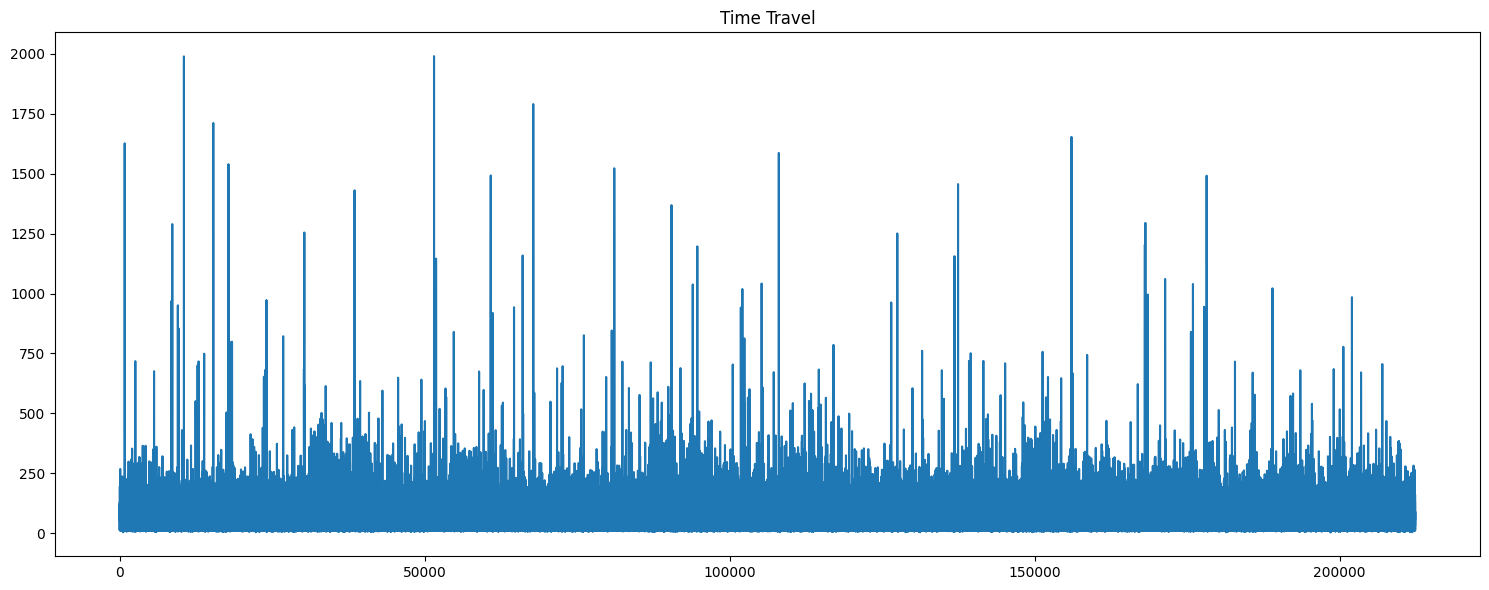

In [7]:
plt.figure(figsize=(15, 6))
data['time_travel'].plot()
plt.ylabel(None)
plt.xlabel(None)
plt.title("Time Travel")
plt.tight_layout()
plt.show()

Observacion de las columnas del dataset

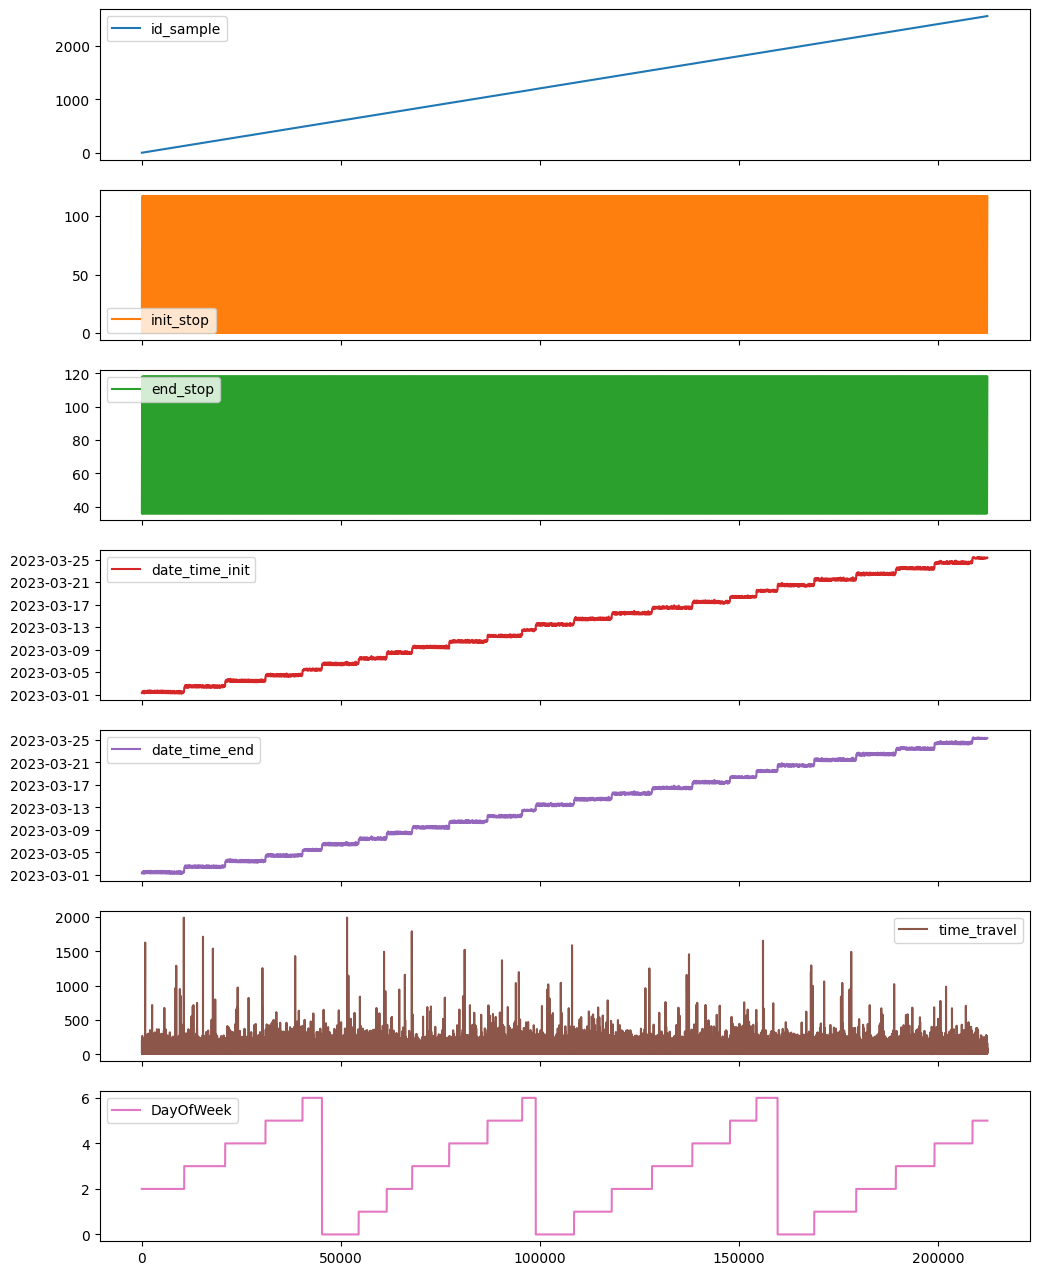

In [8]:
cols = data.columns

# Dibujar la totalidad de registros
N = data.shape[0]       # Número de registros
plots = data[cols][0:N] # Series de tiempo individuales
plots.index = data.index[0:N] # Variable tiempo
_ = plots.plot(subplots=True, figsize=(12,16))


Ajuste de periodicidad, en estas pruebas se considera hacer fracciones de tiempo cada 1 minuto

In [13]:
#Crear una columna que sera indice de periodicidad
ix = pd.DatetimeIndex(pd.to_datetime(data['date_time_init'])).floor('1min')#.floor('10S')#.floor('0.1min')
data["datetime"] = ix

#Crear indice datetime
data.set_index('datetime', inplace= True)
data

,id_sample,init_stop,end_stop,linkref,date_time_init,date_time_end,time_travel,DayOfWeek
datetime,,,,,,,,
2023-03-01 07:20:00,0,0,36,0:36,2023-03-01 07:24:22,2023-03-01 07:27:33,191.0,2
2023-03-01 07:25:00,0,36,37,36:37,2023-03-01 07:27:33,2023-03-01 07:29:19,106.0,2
2023-03-01 07:25:00,0,37,38,37:38,2023-03-01 07:29:19,2023-03-01 07:30:49,90.0,2
2023-03-01 07:30:00,0,38,39,38:39,2023-03-01 07:30:49,2023-03-01 07:31:13,24.0,2
2023-03-01 07:30:00,0,39,40,39:40,2023-03-01 07:31:13,2023-03-01 07:32:29,76.0,2
...,...,...,...,...,...,...,...,...
2023-03-25 07:50:00,2559,113,114,113:114,2023-03-25 07:51:20,2023-03-25 07:51:32,12.0,5
2023-03-25 07:50:00,2559,114,115,114:115,2023-03-25 07:51:32,2023-03-25 07:53:02,90.0,5
2023-03-25 07:50:00,2559,115,116,115:116,2023-03-25 07:53:02,2023-03-25 07:53:14,12.0,5


Elegir un sample y mostrar las diferencias de tiempo para observar los tiempos repetidos que son representados por los 0

In [93]:
#Se filtra un sample y se ejecuta el analisis
df_filtrado = data[data['id_sample'] == 0]
df_time_diffs = df_filtrado.index.to_series().diff().dt.total_seconds()
print(df_time_diffs.value_counts())

60.0     43
0.0      23
120.0    15
180.0     1
Name: datetime, dtype: int64


Elegir todos samples y mostrar las diferencias de tiempo para observar los tiempos repetidos que son representados por los 0

In [94]:
df_list = pd.DataFrame()
#Iterar los samples y concatenar
for value in data['id_sample'].unique():
    df_filtrado = data[data['id_sample'] == value]
    df_time_diffs = df_filtrado.index.to_series().diff().dt.total_seconds()
    df_list = pd.concat([df_list,df_time_diffs], axis=0)

print(df_list.value_counts())

60.0      109196
0.0        63647
120.0      26905
180.0       7280
240.0       1864
300.0        495
360.0        207
420.0         93
480.0         37
540.0         21
600.0         16
660.0         15
720.0         13
960.0          7
1020.0         7
780.0          6
840.0          5
1500.0         4
1140.0         3
1680.0         2
1560.0         2
1980.0         2
1320.0         2
1260.0         2
1200.0         2
1380.0         1
1440.0         1
1620.0         1
1800.0         1
900.0          1
dtype: int64


Guardar dataset procesado

In [95]:
data.to_csv('../data/dataset_v1.csv')

# Crear sets de entrenamiento, validación y prueba

Leer el dataset procesado anteriormente

In [285]:
df = pd.read_csv('../data/dataset_v1.csv', usecols=['datetime','linkref', 'time_travel'])
df.set_index('datetime', inplace= True)
df

,linkref,time_travel
datetime,,
2023-03-01 07:24:00,0:36,191.0
2023-03-01 07:27:00,36:37,106.0
2023-03-01 07:29:00,37:38,90.0
2023-03-01 07:30:00,38:39,24.0
2023-03-01 07:31:00,39:40,76.0
...,...,...
2023-03-25 07:51:00,113:114,12.0
2023-03-25 07:51:00,114:115,90.0
2023-03-25 07:53:00,115:116,12.0


In [286]:
# Supongamos que tienes una columna llamada 'columna' en tu DataFrame 'datos'
columna_strings = df['linkref']

# Obtén la lista única de valores en la columna
valores_unicos = columna_strings.unique()

# Ordena los valores únicos
#valores_unicos_ordenados = sorted(valores_unicos)

# Crea un diccionario para mapear los valores únicos a la codificación numérica
diccionario_codificacion = {valor: indice for indice, valor in enumerate(valores_unicos)}

# Aplica la codificación a la columna
df['links'] = columna_strings.map(diccionario_codificacion)

# Imprime los valores originales y los codificados
print("Valores originales:", df['links'].values)
print("Valores codificados:", df['links'].values)

first_column = df.pop('links')
df.insert(0, 'links', first_column)
df = pd.DataFrame(df.drop('linkref', axis=1))
df

Valores originales: [ 0  1  2 ... 80 81 82]
Valores codificados: [ 0  1  2 ... 80 81 82]


,links,time_travel
datetime,,
2023-03-01 07:24:00,0,191.0
2023-03-01 07:27:00,1,106.0
2023-03-01 07:29:00,2,90.0
2023-03-01 07:30:00,3,24.0
2023-03-01 07:31:00,4,76.0
...,...,...
2023-03-25 07:51:00,78,12.0
2023-03-25 07:51:00,79,90.0
2023-03-25 07:53:00,80,12.0


In [5]:
#from sklearn.preprocessing import MinMaxScaler
#scaler_time_travel = MinMaxScaler()
#scaler_links = MinMaxScaler()

#df['time_travel'] = df['time_travel'].astype(float)  # Convertir a punto flotante
#df['time_travel'] = scaler_time_travel.fit_transform(df['time_travel'].values.reshape(-1, 1))

#df['links'] = df['links'].astype(float)  # Convertir a punto flotante
#df['links'] = scaler_links.fit_transform(df['links'].values.reshape(-1, 1))

#df

In [6]:
# Realizar la transformación inversa de 'time_travel'
#df['time_travel2'] = scaler_time_travel.inverse_transform(df['time_travel'].values.reshape(-1, 1))

# Realizar la transformación inversa de 'links'
#df['links2'] = scaler_links.inverse_transform(df['links'].values.reshape(-1, 1))

# Verificar el resultado
#print(df)

Separar datos 

In [109]:
def train_val_test_split(serie, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    # Definir número de datos en cada subserie
    N = serie.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = serie[0:Ntrain]
    val = serie[Ntrain:Ntrain+Nval]
    test = serie[Ntrain+Nval:]

    return train, val, test

separar datos samples

In [287]:
def train_val_test_split_samples(dataset, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    # dividir el dataset por nro de samples
    n_sample = dataset.shape[0] / 83

    # Definir número de datos en cada subserie
    N = dataset.shape[0]
    Ntrain = int(n_sample * tr_size) * 83 # Número de datos de entrenamiento
    Nval = int(n_sample * vl_size) * 83   # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = dataset[0:Ntrain]
    val = dataset[Ntrain:Ntrain+Nval]
    test = dataset[Ntrain+Nval:]

    return train, val, test

Se dispondra que del total de samples:
  - 80% seran para entrenamiento
  - 10% para validación 
  - 10% para test

In [298]:
tr_size=0.8
vl_size=0.1 
ts_size=0.1

#tr, vl, ts = train_val_test_split(df)

#tr_size=170067 #80% aproximadamente
#vl_size=21165  #10% aproximadamente
#ts_size=21165  #10% aproximadamente

tr, vl, ts = train_val_test_split_samples(df)

# Imprimir en pantalla el tamaño de cada subset
print(f'Tamaño total de datos      ({100}%):  {df.shape[0]}')
print(f'Tamaño set de entrenamiento ({int(tr_size*100)}%):  {tr.shape} ({int(tr.shape[0]/83)} samples)')
print(f'Tamaño set de validación    ({int(vl_size*100)}%):  {vl.shape} ({int(vl.shape[0]/83)} samples)')
print(f'Tamaño set de prueba        ({int(ts_size*100)}%):  {ts.shape} ({int(ts.shape[0]/83)} samples)')

Tamaño total de datos      (100%):  212397
Tamaño set de entrenamiento (80%):  (169901, 2) (2047 samples)
Tamaño set de validación    (10%):  (21165, 2) (255 samples)
Tamaño set de prueba        (10%):  (21331, 2) (257 samples)


Mostrar los datos que se han dividido

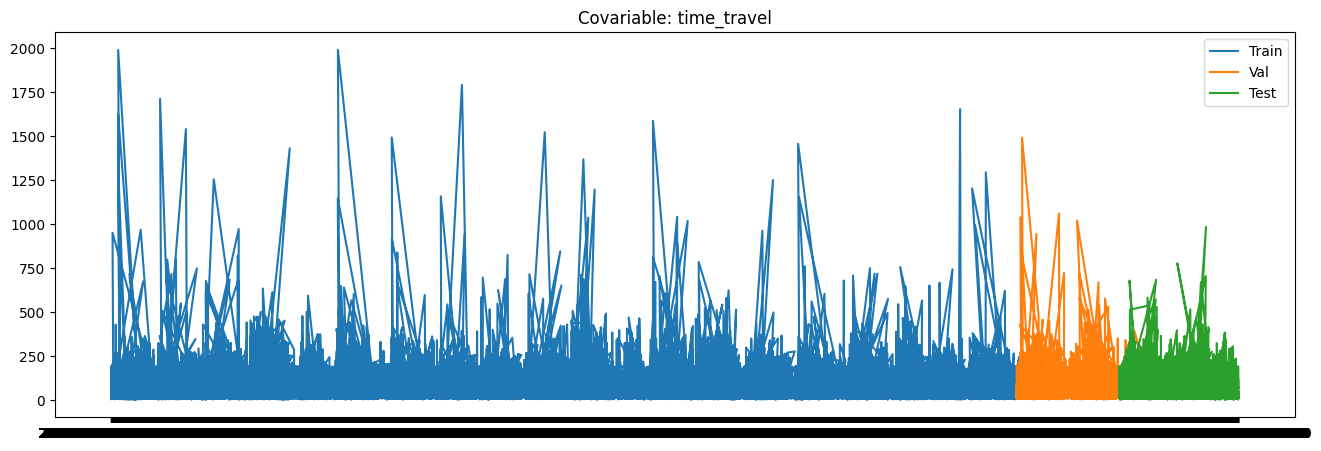

In [289]:
covar = 1 # Índice de la covariable (columna del dataset) a graficar
col = df.columns[covar]

# Dibujar los sets de entrenamiento/validación/prueba para la covariable
fig, ax = plt.subplots(figsize = (16,5))
ax.plot(tr[col], label='Train')
ax.plot(vl[col], label='Val')
ax.plot(ts[col], label='Test')
ax.set_title(f'Covariable: {col}')
plt.legend();

Generar los datasets normalizados y organizar secuencias

In [301]:
def crear_dataset_supervisado(array, input_length, output_length):
    '''Permite crear un dataset con las entradas (X) y salidas (Y)
    requeridas por la Red LSTM.

    Parámetros:
    - array: arreglo numpy de tamaño N x features (N: cantidad de datos, f: cantidad de features)
    - input_length: instantes de tiempo consecutivos de la(s) serie(s) de tiempo usados para alimentar el modelo
    - output_length: instantes de tiempo a pronosticar (salida del modelo)
    '''

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado
        fils, cols = array.shape

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+input_length,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))
    
    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)
    
    return X, Y

In [309]:
# Crear los datasets de entrenamiento, prueba y validación y verificar sus tamaños
INPUT_LENGTH = 83    # Posteriormente afinaremos este hiperparámetro
OUTPUT_LENGTH = 1    # Modelo uni-step

x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

# Imprimir información en pantalla
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (169817, 83, 2), y_tr: (169817, 1, 1)
Set de validación - x_vl: (21081, 83, 2), y_vl: (21081, 1, 1)
Set de prueba - x_ts: (21247, 83, 2), y_ts: (21247, 1, 1)


In [310]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

def escalar_dataset(data_input, col_ref):
    '''Escala el dataset en el rango de -1 a 1.

    Entradas:
    - data_input: diccionario con los dataset de entrada y salida del modelo
    (data_input = {'x_tr':x_tr, 'y_tr':y_tr, 'x_vl':x_vl, 'y_vl':y_vl,
                    'y_ts':y_ts})
    - col_ref: parámetro adicional para especificar la columna que contiene
      la variable a predecir

    
    Retorna:
    - data_scaled: diccionario con los datasets de entrada y salida escalados
      (tiene la misma estructura del diccionario de entrada)
    - scaler: el escalador usado (requerido para las predicciones)
    '''

    # *** Implementación adicional: determinar el índice de la columna
    # que contiene la variable a predecir
    col_ref = df.columns.get_loc(col_ref)

    # Número de instantes de tiempo de entrada y de covariables
    NFEATS = data_input['x_tr'].shape[2]

    # Generar listado con "scalers" (1 por cada covariable de entrada)
    #scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]
    scalers = [StandardScaler() for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])
    
    # Escalamiento Ys (teniendo en cuenta "col_ind")
    y_tr_s[:,:,0] = scalers[col_ref].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[col_ref].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[col_ref].transform(y_ts[:,:,0])

    # Conformar diccionario de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[col_ref]

In [311]:
# Escalamiento del dataset con la función anterior

# Crear diccionario de entrada
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

# Y escalar
data_s, scaler = escalar_dataset(data_in, col_ref = 'time_travel')

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

# Verificación
print(f'Min x_tr/x_vl/x_ts sin escalamiento: {x_tr.min()}/{x_vl.min()}/{x_ts.min()}')
print(f'Min x_tr/x_vl/x_ts con escalamiento: {x_tr_s.min()}/{x_vl_s.min()}/{x_ts_s.min()}')

print(f'\nMin y_tr/y_vl/y_ts sin escalamiento: {y_tr.min()}/{y_vl.min()}/{y_ts.min()}')
print(f'Min y_tr/y_vl/y_ts con escalamiento: {y_tr_s.min()}/{y_vl_s.min()}/{y_ts_s.min()}')

print(f'\nMax x_tr/x_vl/x_ts sin escalamiento: {x_tr.max()}/{x_vl.max()}/{x_ts.max()}')
print(f'Max x_tr/x_vl/x_ts con escalamiento: {x_tr_s.max()}/{x_vl_s.max()}/{x_ts_s.max()}')

print(f'\nMax y_tr/y_vl/y_ts sin escalamiento: {y_tr.max()}/{y_vl.max()}/{y_ts.max()}')
print(f'Max y_tr/y_vl/y_ts con escalamiento: {y_tr_s.max()}/{y_vl_s.max()}/{y_ts_s.max()}')

Min x_tr/x_vl/x_ts sin escalamiento: 0.0/0.0/0.0
Min x_tr/x_vl/x_ts con escalamiento: -1.7113267308558235/-1.7113267308558235/-1.7113267308558235

Min y_tr/y_vl/y_ts sin escalamiento: 4.0/4.0/3.0
Min y_tr/y_vl/y_ts con escalamiento: -1.062214803061375/-1.062214803061375/-1.0823707445143504

Max x_tr/x_vl/x_ts sin escalamiento: 1991.0/1492.0/985.0
Max x_tr/x_vl/x_ts con escalamiento: 38.99186732174957/28.93297462088855/18.71281710718808

Max y_tr/y_vl/y_ts sin escalamiento: 1991.0/1492.0/985.0
Max y_tr/y_vl/y_ts con escalamiento: 38.98764086400076/28.929826078966034/18.7107637623075


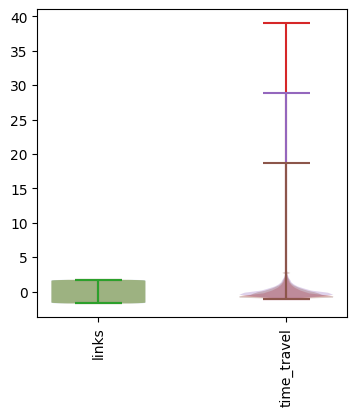

In [255]:
# Y generemos una gráfica tipo violín para ver la distribución
# de los valores en cada covariable (entrada) y en la variable a
# predecir (salida)

fig, ax = plt.subplots(figsize=(4,4))
for i in range(2):
    ax.violinplot(dataset=x_tr_s[:,:,i].flatten(), positions=[i])
    ax.violinplot(dataset=x_vl_s[:,:,i].flatten(), positions=[i])
    ax.violinplot(dataset=x_ts_s[:,:,i].flatten(), positions=[i])

# Etiquetas eje horizontal
ax.set_xticks(list(range(2)))
ax.set_xticklabels(df.keys(), rotation=90)
ax.autoscale();

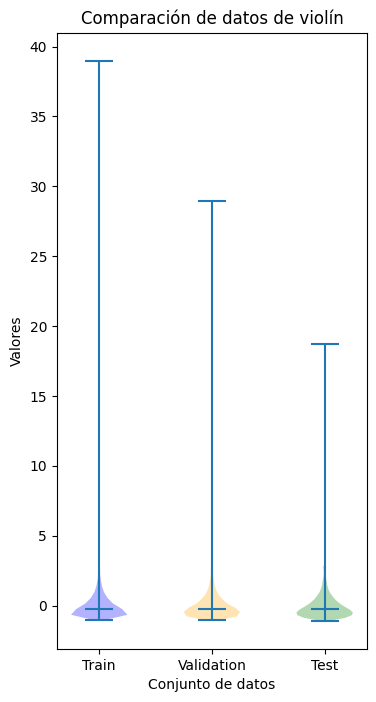

In [270]:
# Crear figura y ejes
fig, ax = plt.subplots(figsize=(4, 8))

# Datos de violín
data = [y_tr_s.flatten(), y_vl_s.flatten(), y_ts_s.flatten()]

# Colores para los violines
colors = ['blue', 'orange', 'green']

# Posiciones de los violines
positions = [1, 2, 3]

# Crear los gráficos de violín
violins=ax.violinplot(dataset=data, positions=positions, showmeans=False, showmedians=True)

# Ajustar etiquetas y colores
ax.set_xticks(positions)
ax.set_xticklabels(['Train', 'Validation', 'Test'])
for patch, color in zip(violins['bodies'], colors):
    patch.set_facecolor(color)

# Ajustar el título y los ejes
ax.set_title('Comparación de datos de violín')
ax.set_xlabel('Conjunto de datos')
ax.set_ylabel('Valores')

# Mostrar el gráfico
plt.show()

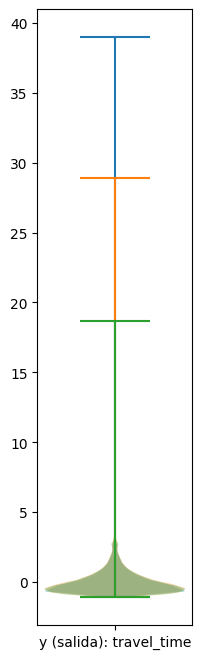

In [264]:
# Y hagamos lo mismo con la variable de salida:
fig, ax = plt.subplots(figsize=(2,8))
ax.violinplot(dataset=y_tr_s.flatten())
ax.violinplot(dataset=y_vl_s.flatten())
ax.violinplot(dataset=y_ts_s.flatten())
ax.set_xticks([1])
ax.set_xticklabels(['y (salida): travel_time']);

In [312]:
# Creación del modelo
from keras.models import Sequential
#from tensorflow.keras.layers import CuDNNLSTM, Dense
from keras.layers import LSTM, Dense
from keras.optimizers import RMSprop, Adam
import tensorflow as tf

# Ajustar parámetros para reproducibilidad del entrenamiento
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()

# El modelo
N_UNITS = 128 # Tamaño del estado oculto (h) y de la celdad de memoria (c) (128)
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) # 24 (horas) x 13 (features)

modelo = Sequential()
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))

# Y lo único que cambia con respecto al modelo multivariado + uni-step es
# el tamaño deldato de salida
modelo.add(Dense(OUTPUT_LENGTH, activation='linear')) # activation = 'linear' pues queremos pronosticar (regresión)

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la temperatura
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

# Compilación
optimizador = RMSprop(learning_rate=5e-4) # 5e-5
modelo.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

# Entrenamiento (aproximadamente 8 min usando GPU)
EPOCHS = 80 # Hiperparámetro
BATCH_SIZE = 256 # Hiperparámetro
historia = modelo.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)

Epoch 1/80
664/664 - 8s - loss: 0.8202 - val_loss: 0.7685 - 8s/epoch - 13ms/step
Epoch 2/80
664/664 - 6s - loss: 0.7670 - val_loss: 0.7608 - 6s/epoch - 10ms/step
Epoch 3/80
664/664 - 6s - loss: 0.7445 - val_loss: 0.7275 - 6s/epoch - 10ms/step
Epoch 4/80
664/664 - 7s - loss: 0.7240 - val_loss: 0.7361 - 7s/epoch - 10ms/step
Epoch 5/80
664/664 - 6s - loss: 0.7141 - val_loss: 0.7150 - 6s/epoch - 10ms/step
Epoch 6/80
664/664 - 7s - loss: 0.7131 - val_loss: 0.7345 - 7s/epoch - 10ms/step
Epoch 7/80
664/664 - 8s - loss: 0.7066 - val_loss: 0.7162 - 8s/epoch - 11ms/step
Epoch 8/80
664/664 - 9s - loss: 0.6996 - val_loss: 0.6788 - 9s/epoch - 14ms/step
Epoch 9/80
664/664 - 10s - loss: 0.6931 - val_loss: 0.6750 - 10s/epoch - 14ms/step
Epoch 10/80
664/664 - 9s - loss: 0.6858 - val_loss: 0.6839 - 9s/epoch - 14ms/step
Epoch 11/80
664/664 - 10s - loss: 0.6820 - val_loss: 0.6792 - 10s/epoch - 15ms/step
Epoch 12/80
664/664 - 9s - loss: 0.6774 - val_loss: 0.6618 - 9s/epoch - 14ms/step
Epoch 13/80
664/664 -

In [313]:
modelo.save('Standard_Scaler_LSTM-1min_.h5')

In [314]:
from keras.models import load_model

# cargar modelo
#modelo = load_model('LSTM-1min_.h5')
modelo = load_model('Standard_Scaler_LSTM-1min_.h5', compile=False)
modelo.compile(optimizer = optimizador, loss = root_mean_squared_error)

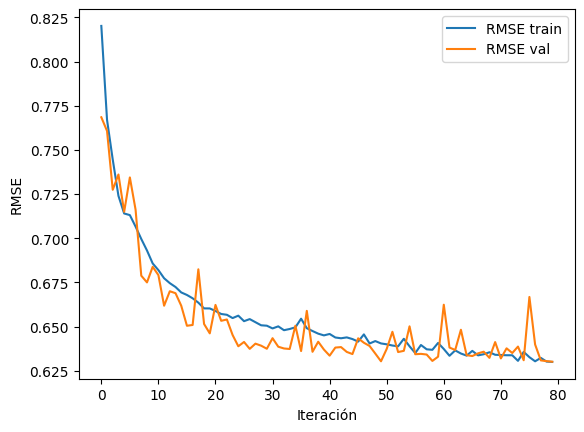

In [315]:
 # Graficar curvas de entrenamiento y validación
 # para verificar que no existe overfitting
plt.plot(historia.history['loss'],label='RMSE train')
plt.plot(historia.history['val_loss'],label='RMSE val')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend();

In [316]:
# Cálculo de rmses para train, val y test
rmse_tr = modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.561
  RMSE val:	 0.570
  RMSE test:	 0.546


In [317]:
def predecir(x, model, scaler):
    '''Genera la predicción de OUTPUT_LENGTH instantes
    de tiempo a futuro con el modelo entrenado.

    Entrada:
    - x: batch (o batches) de datos para ingresar al modelo
      (tamaño: BATCHES X INPUT_LENGTH X FEATURES)
    - model: Red LSTM entrenada
    - scaler: escalador (requerido para llevar la predicción a la escala original)
    
    Salida:
    - y_pred: la predicción en la escala original (tamaño: BATCHES X OUTPUT_LENGTH X FEATURES)
    '''

    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

In [318]:
# Calcular predicciones sobre el set de prueba
y_ts_pred = predecir(x_ts_s, modelo, scaler)

In [319]:
# Calcular predicciones sobre el set de entrenamiento
y_train_predictions = predecir(x_tr_s, modelo, scaler)

### Calcular el error simple 

error promedio:  0.9522501886740973


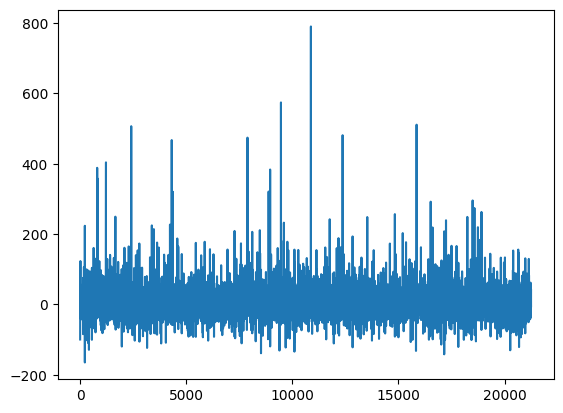

In [320]:
N = len(y_ts_pred)    # Número de predicciones
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
error = y_ts.flatten()-y_ts_pred
plt.plot(error);
print('error promedio: ', np.mean(error))

Incertidumbre de valores predecidos en general

In [321]:
# Calcula los residuos
residuos = error

# Define el nivel de confianza deseado (por ejemplo, 95%)
nivel_confianza = 95

# Calcula el percentil inferior y superior del intervalo
percentil_inferior = (100 - nivel_confianza) / 2
percentil_superior = 100 - percentil_inferior

# Calcula el intervalo simétrico utilizando los percentiles
intervalo_simetrico = np.percentile(residuos, [percentil_inferior, percentil_superior])

print("Intervalo simétrico:", intervalo_simetrico)

Intervalo simétrico: [-43.7977932   61.92089195]


Tema de discusion

In [347]:
from scipy import stats

# Calcula los residuos
residuos = error

# Calcula la media y la desviación estándar de los residuos
media = np.mean(residuos)
desviacion_estandar = np.std(residuos)

# Define el nivel de confianza deseado (por ejemplo, 95%)
nivel_confianza = 0.95

# Calcula el margen de error
valor_critico = stats.t.ppf((1 + nivel_confianza) / 2, len(y_ts_pred) - 1)
margen_error = valor_critico * desviacion_estandar

# Calcula el intervalo simétrico
valor_predicho = y_ts_pred[-1]  # Último valor predicho en la lista
intervalo_simetrico = [valor_predicho - margen_error, valor_predicho + margen_error]
print("Intervalo simétrico:", intervalo_simetrico)
margen_error

Intervalo simétrico: [-41.54305670527638, 75.35239432124317]


58.447725513259776

In [325]:
# from scipy.stats import t
# def calcular_margen_error_tiempos(tiempos_reales, tiempos_predichos, nivel_confianza):
#     # Calcular las diferencias entre los tiempos reales y los tiempos predichos
#     diferencias = tiempos_reales - tiempos_predichos
    
#     # Calcular el promedio de las diferencias
#     promedio_diferencias = np.mean(diferencias)
    
#     # Calcular la desviación estándar de las diferencias
#     desviacion_estandar_diferencias = np.std(diferencias)
    
#     # Calcular el tamaño de la muestra
#     n = len(diferencias)
    
#     # Calcular el valor crítico de la distribución t de Student para el nivel de confianza dado
#     valor_critico = t.ppf(1 - (1 - nivel_confianza) / 2, n - 1)
    
#     # Calcular el margen de error
#     margen_error = valor_critico * desviacion_estandar_diferencias / np.sqrt(n)
    
#     return diferencias, margen_error

In [ ]:
# diferencias, margen_error = calcular_margen_error_tiempos(np.array(y_ts.flatten()),np.array(y_ts_pred), 0.95)
# print(np.mean(diferencias), margen_error)

## Muestras de predicciones

In [333]:
def generar_rangos(numero):
    base = 83
    inicio = (numero - 1) * base
    fin = numero * base
    return inicio, fin

def plot_predict_samples(sample, df, y_train_predictions):

    plt.figure(figsize=(17, 6))
    # Elegir sample

    variable1, variable2 = generar_rangos(sample)

    links_83 = np.arange(83)
    sample_train = df['time_travel'][variable1:variable2].values.reshape(-1, 1)
    sample_predicted = y_train_predictions[variable1:variable2].reshape(-1, 1)

    plt.plot(links_83,sample_train, label='data train',marker='o')
    plt.plot(links_83,sample_predicted, label='predicciones',marker='o')

    # Trazar una línea entrecortada entre los puntos
    #for i in range(len(links_83)):
    #    plt.plot([links_83[i], links_83[i]], [sample_train[i], sample_predicted[i]], 'g--')

    # Ajustar los límites de los ejes
    plt.xlim(-1, 83)  # Ajustar límites del eje x
    #plt.ylim(0, 200)  # Ajustar límites del eje y

    plt.xlabel('Links (tramos entre paraderos)')
    plt.ylabel('Time travel')
    plt.legend()
    plt.title("PREDICCION PARA EL SAMPLE "+ str(sample) +" DEL CONJUNTO DE ENTRENAMIENTO")

    # Mostrar el gráfico
    plt.show();

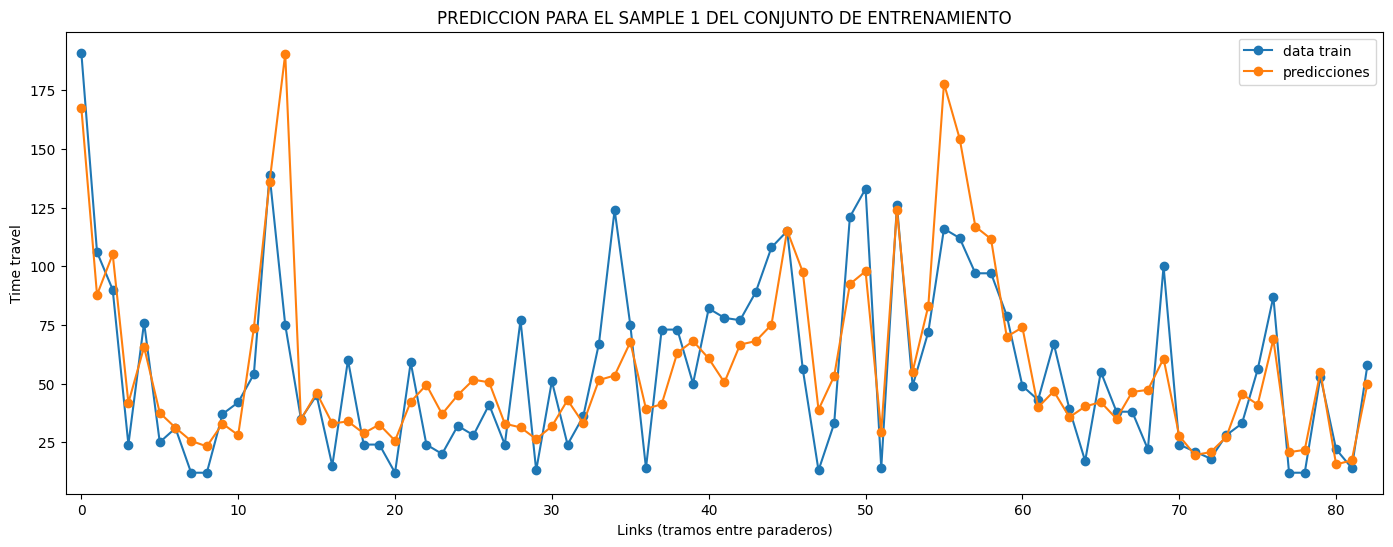

In [334]:
plot_predict_samples(1,df,y_train_predictions)

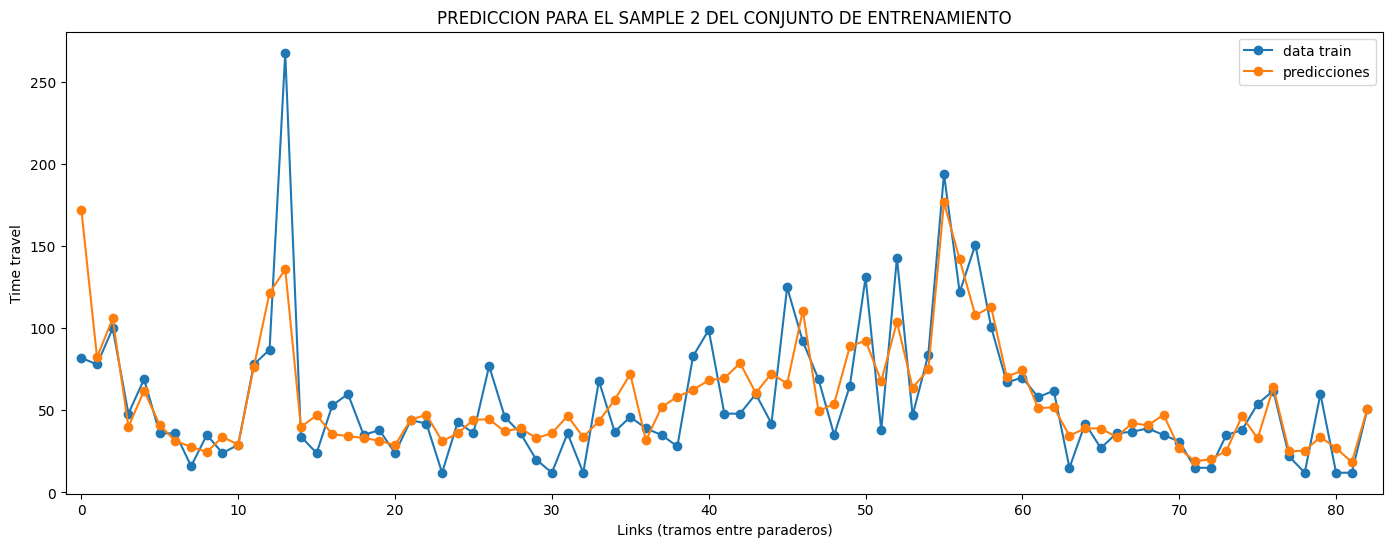

In [335]:
plot_predict_samples(2,df,y_train_predictions)

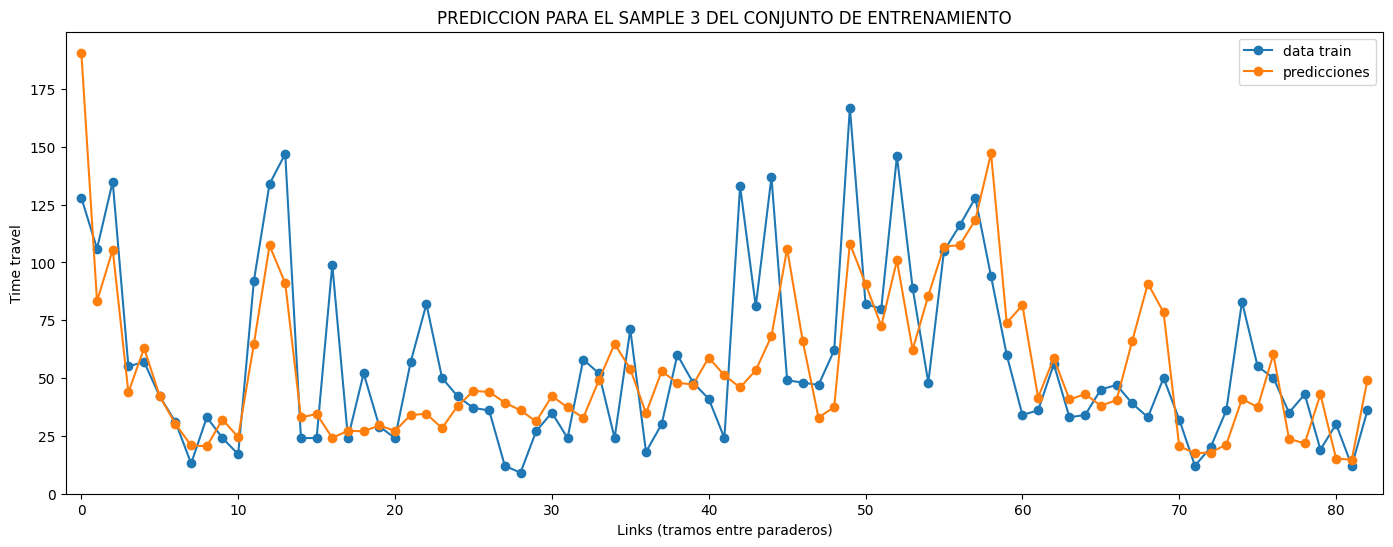

In [336]:
plot_predict_samples(3,df,y_train_predictions)

# Prediccion de paraderos uni-step

In [388]:
def prediccion_links(last_secuence, paraderoA, paraderoB, stops):
    # Tiempos
    times_sum = []

    for i in range(paraderoB):
        #print(i)
        #Dimension para predecir (1,[0-83],2)
        prueba_prediccion = modelo.predict(last_secuence,verbose=0)
        prueba_prediccion_escalado = scaler.inverse_transform(prueba_prediccion)

        #Ultimo elemento a agregar
        last_element = np.array([[last_secuence[0][0][0], prueba_prediccion]], dtype=object)

        #Agregar el ultimo elemento de prediccion no escalado y eliminar el primero
        last_secuence = np.append(np.squeeze(last_secuence), last_element,axis=0)[1:,:].reshape(1,83, 2).astype(np.float64)

        times_sum.append(prueba_prediccion_escalado[0][0])
        #print(i, last_secuence.shape, last_secuence.dtype)

    print("La prediccion del paradero '",stops[paraderoA],"' al paradero '", stops[paraderoB], "' es: ", sum(times_sum[paraderoA:paraderoB+1]))
    return sum(times_sum[paraderoA:paraderoB+1])


## Realizar predicciones

In [389]:
paraderos = pd.read_csv('../data/busstops_ida.csv', usecols=['number','name'])
stops = dict(zip(paraderos['number'], paraderos['name']))
#stops

In [390]:
first_sample_test = x_tr_s[0].reshape(1,83, 2)
#last_sample_test = x_vl_s[-1].reshape(1,83, 2)
#±

predict_paraderos = prediccion_links(first_sample_test, 0, 45, stops)
print(f"{predict_paraderos:.2f} segundos equivale a {(predict_paraderos/60):.2f} minutos con un margen de error de [{intervalo_simetrico[0]:.3f}, +{intervalo_simetrico[1]:.3f}] segundos")

La prediccion del paradero ' inicio ' al paradero ' Hospital regional ' es:  2443.287124633789
2443.29 segundos equivale a 40.72 minutos con un margen de error de [-41.543, +75.352] segundos


# FIN PRUEBAS